# Layers

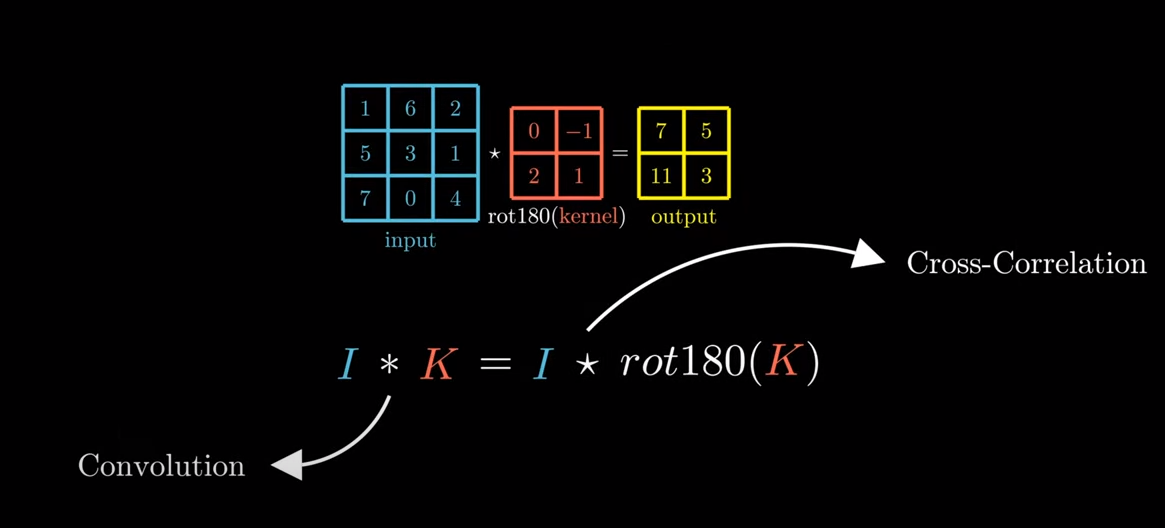


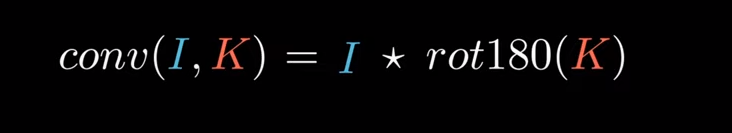

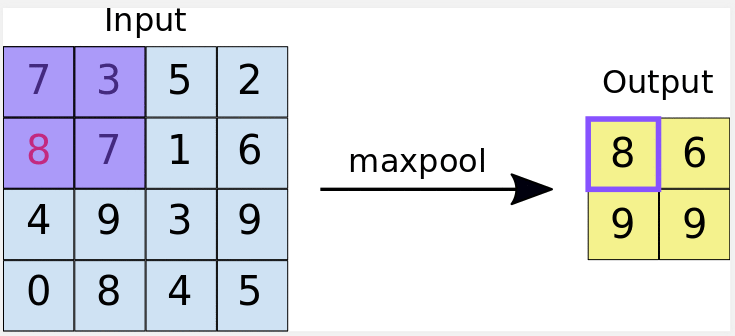

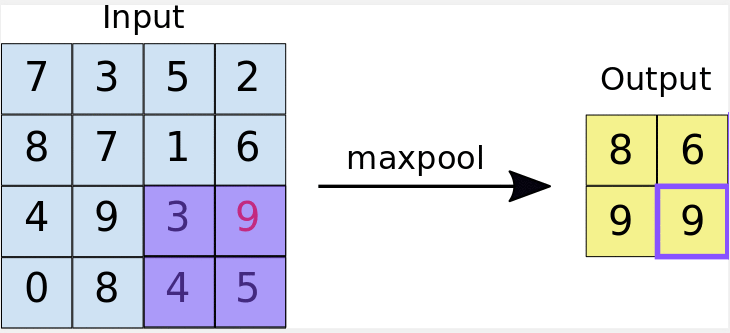

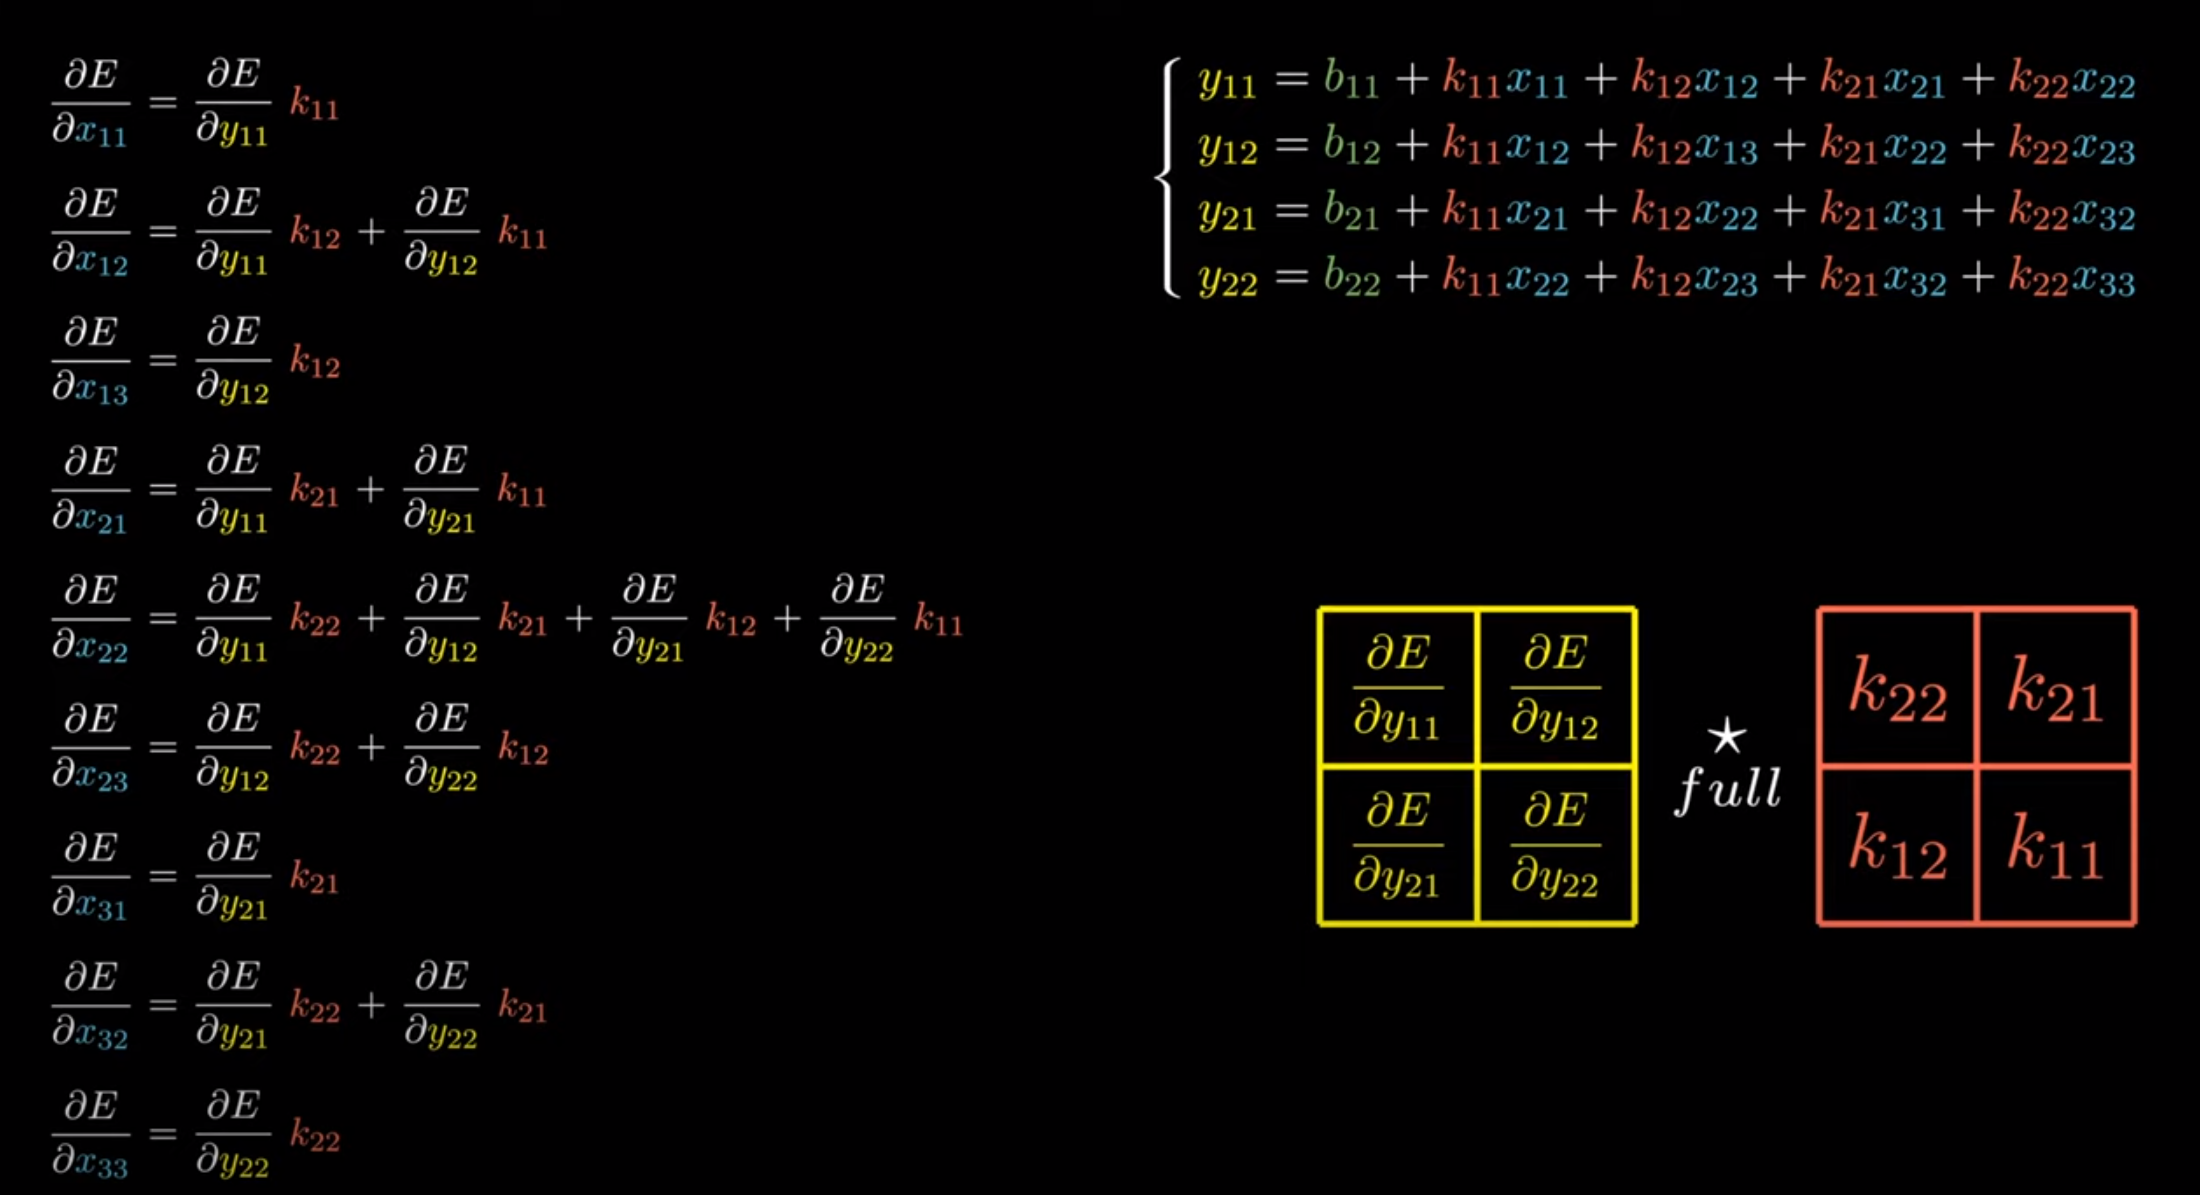


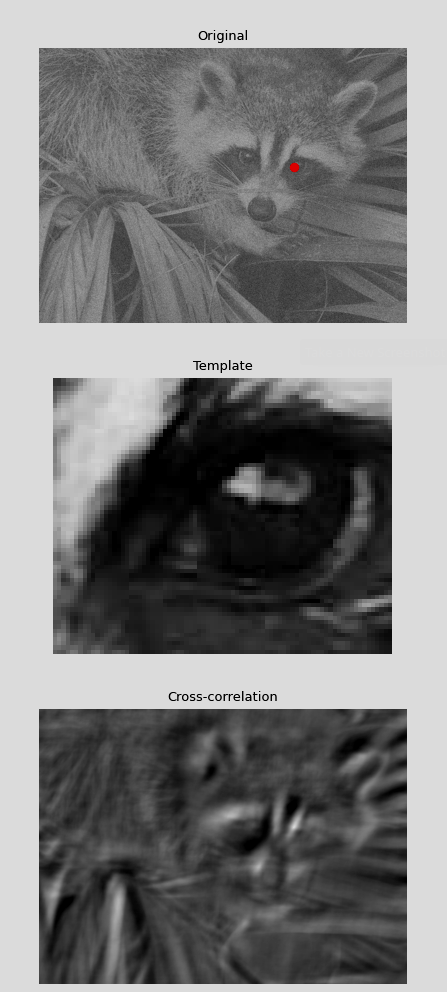

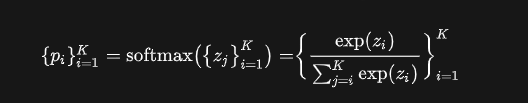

In [ ]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from scipy import signal

class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

class Dense(Layer):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.weights = np.random.randn(out_size, in_size)
        self.bias = np.random.randn(out_size, 1)

    def forward(self, input):
        self.input = np.array(input, dtype = np.float64)
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, grad, learning_rate):
        grad = np.array(grad, dtype = np.float64)
        weights_grad = np.dot(grad, self.input.T)
        input_gradient = np.dot(self.weights.T, grad)
        self.weights -= learning_rate * weights_grad
        self.bias -= learning_rate * grad
        return input_gradient

class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        super().__init__()
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, grad, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], grad[i], "valid")
                input_gradient[j] += signal.convolve2d(grad[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * grad
        return input_gradient

class MaxPooling(Layer):
    def __init__(self, pool_size):
        super().__init__()
        self.pool_size = pool_size

    def forward(self, input):
        self.input = input
        depth, height, width = input.shape
        pooled_height = height // self.pool_size
        pooled_width = width // self.pool_size
        self.output = np.zeros((depth, pooled_height, pooled_width))

        for i in range(depth):
            for j in range(pooled_height):
                for k in range(pooled_width):
                    h1 = j * self.pool_size
                    h2 = h1 + self.pool_size
                    w1 = k * self.pool_size
                    w2 = w1 + self.pool_size
                    partition = input[i, h1 : h2, w1 : w2]
                    self.output[i, j, k] = np.max(partition)

        return self.output

    def backward(self, grad, learning_rate):
        depth, pooled_height, pooled_width = grad.shape
        input_gradient = np.zeros_like(self.input)

        for i in range(depth):
            for j in range(pooled_height):
                for k in range(pooled_width):
                    h1 = j * self.pool_size
                    h2 = h1 + self.pool_size
                    w1 = k * self.pool_size
                    w2 = w1 + self.pool_size
                    partition = self.input[i, h1 : h2, w1 : w2]
                    mx_val = np.max(partition)
                    template = (partition == mx_val)
                    input_gradient[i, h1 : h2, w1 : w2] += template * grad[i, j, k]

        return input_gradient


class Activation():
    def __init__(self, activation, activation_prime):
        super().__init__()
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, grad, learning_rate):
        return np.multiply(grad, self.activation_prime(self.input))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

class Sigmoid(Activation):
    def __init__(self):
        super().__init__(sigmoid, sigmoid_derivative)


class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, grad, learning_rate):
        return np.reshape(grad, self.input_shape)

# Metrics

In [ ]:
def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_deriv(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Read dataset and preprocessing it

In [ ]:
def preprocessing(val, ans, count):
    val = val.reshape(val.shape[0], 1,  28, 28)
    val = val.astype("float32") / 255
    ans = to_categorical(ans)
    ans = ans.reshape(ans.shape[0], 10, 1)
    return val[:count], ans[:count]


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocessing(x_train, y_train, 15000)
x_test, y_test = preprocessing(x_test, y_test, 3000)
print(y_train.shape[0], y_test.shape[0])

15000 3000


# CNN train and prediction

In [ ]:
def run_predict(layers, input):
    current_output = input
    for layer in layers:
        current_output = layer.forward(current_output)
    return current_output

def model_train(layers, loss, loss_prime, x_train, y_train):
    for i in range(10):
        err = 0
        for x, y in zip(x_train, y_train):
            output = run_predict(layers, x)
            err += loss(y, output)
            grad = loss_prime(y, output)
            for layer in reversed(layers):
                grad = layer.backward(grad, 0.1)

        print(f"{i + 1}/{10}, error={err / len(x_train)}")

def check_prediction(layers, input_data, output_data, loss) -> np.array:
    error = 0
    predictions = []
    for x, y in zip(input_data, output_data):
        output = run_predict(layers, x)
        predictions.append(output)
        error += loss(y, output)

    error /= len(input_data)
    predictions = np.array(predictions)
    return error, predictions


dense = 32
kernel1 = 5
kernels1 = 5
kernel2 = 5
kernels2 = 3

b = (28 - kernel1 + 1) // 2
c = b - kernel2 + 1

layers = [
    Convolutional((1, 28, 28), kernel1, kernels1),
    Sigmoid(),
    MaxPooling(2),
    Convolutional((kernels1, b, b), kernel2, kernels2),
    Sigmoid(),
    Reshape((kernels2, c, c), (kernels2 * c * c, 1)),
    Dense(kernels2 * c * c, dense),
    Sigmoid(),
    Dense(dense, 10),
    Sigmoid()
]

model_train(layers, binary_cross_entropy, binary_cross_entropy_deriv, x_train, y_train)

predictions = check_prediction(layers, x_test, y_test, binary_cross_entropy)

1/10, error=0.24819067354125396
2/10, error=0.11853865225899637
3/10, error=0.08631195877593309
4/10, error=0.07098895139211212
5/10, error=0.06188657525863604
6/10, error=0.05567385458626309
7/10, error=0.051039661833472395
8/10, error=0.04745366795073988
9/10, error=0.04463781601460414
10/10, error=0.04215618511046329


# Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def predictions_to_labels(predictions):
    return predictions.argmax(axis = 1)

y_pred = predictions_to_labels(predictions.squeeze())
y_true = y_test.argmax(axis = 1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average = 'weighted', zero_division = 1)
recall = recall_score(y_true, y_pred, average = 'weighted')
f1 = f1_score(y_true, y_pred, average = 'weighted')

print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1 Score: {f1}")

AttributeError: 'tuple' object has no attribute 'squeeze'